# Data exploration

In this notebook, we review the dataset to understand what the data represent and the relationship between data elements. This also includes dealing with the null values and defining the preprocessing function.


### Import statements

In [263]:
pip install --upgrade seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 23.3.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [264]:
# Import statements 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 1° Loading the dataset

In [265]:
filepath = '../../RFQ_Data_Challenge_HEC.csv'
df = pd.read_csv(filepath)
df.head()

/var/folders/h7/_dgsjjs93hv7lr5ql2ffz2_c0000gn/T/ipykernel_71306/1895652701.py:2: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


,Deal_Date,ISIN,cusip,Instrument,Sales_Name,Sales_Initial,company_short_name,B_Price,B_Side,Total_Requested_Volume,...,MidYTM,YTWDate,SpreadvsBenchmarkMid,MidASWSpread,MidZSpread,GSpreadMid,MidModifiedDuration,MidConvexity,MidEffectiveDuration,MidEffectiveConvexity
0,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 25/2/2025 2.500,Blanca Tailpied,BLA,Bnp Reunion,0.0,NATIXIS SELL,77551,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
1,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 25/2/2025 2.500,Blanca Tailpied,BLA,Cegi Ett,0.0,NATIXIS SELL,8163,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
2,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 25/2/2025 2.500,Blanca Tailpied,BLA,Qbe,0.0,NATIXIS SELL,20408,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
3,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 2.5% 25 FEB 2025,Blanca Tailpied,BLA,Cegi Ett,0.0,NATIXIS SELL,16327,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
4,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 2.5% 25 FEB 2025,Constantin Durie,CON,Scp Laureau-Jeannerot,0.0,NATIXIS SELL,244898,...,5.57551,NaN,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874


In [269]:
df.columns

Index(['Deal_Date', 'ISIN', 'cusip', 'Instrument', 'Sales_Name',
       'Sales_Initial', 'company_short_name', 'B_Price', 'B_Side',
       'Total_Requested_Volume', 'Total_Traded_Volume_Natixis',
       'Total_Traded_Volume_Away', 'Total_Traded_Volume',
       'BloomIndustrySector', 'BloomIndustryGroup', 'BloomIndustrySubGroup',
       'cdcissuerShortName', 'cdcissuer', 'Country', 'lb_Platform_2',
       'maturity', 'Rating_Fitch', 'Rating_Moodys', 'Rating_SP', 'Cusip',
       'Ccy', 'Classification', 'Tier', 'Maturity', 'AssumedMaturity',
       'Coupon', 'Frequency', 'Type', 'MidPrice', 'MidYTM', 'YTWDate',
       'SpreadvsBenchmarkMid', 'MidASWSpread', 'MidZSpread', 'GSpreadMid',
       'MidModifiedDuration', 'MidConvexity', 'MidEffectiveDuration',
       'MidEffectiveConvexity'],
      dtype='object')

In [268]:
df.maturity

0         2025-02-25 00:00:00.000
1         2025-02-25 00:00:00.000
2         2025-02-25 00:00:00.000
3         2025-02-25 00:00:00.000
4         2025-02-25 00:00:00.000
                   ...           
635450    2026-04-13 00:00:00.000
635451    2025-01-31 00:00:00.000
635452    2024-07-05 00:00:00.000
635453                       EMEA
635454                     FRANCE
Name: maturity, Length: 635455, dtype: object

In [267]:
df.Maturity

0         02/25/2025 00:00:00
1         02/25/2025 00:00:00
2         02/25/2025 00:00:00
3         02/25/2025 00:00:00
4         02/25/2025 00:00:00
                 ...         
635450    04/13/2027 00:00:00
635451    01/31/2025 00:00:00
635452    10/05/2024 00:00:00
635453    03/21/2082 00:00:00
635454    11/28/2025 00:00:00
Name: Maturity, Length: 635455, dtype: object

### 2° Defining the preprocessing function

In [122]:
df.columns

Index(['Deal_Date', 'ISIN', 'cusip', 'Instrument', 'Sales_Name',
       'Sales_Initial', 'company_short_name', 'B_Price', 'B_Side',
       'Total_Requested_Volume', 'Total_Traded_Volume_Natixis',
       'Total_Traded_Volume_Away', 'Total_Traded_Volume',
       'BloomIndustrySector', 'BloomIndustryGroup', 'BloomIndustrySubGroup',
       'cdcissuerShortName', 'cdcissuer', 'Country', 'lb_Platform_2',
       'maturity', 'Rating_Fitch', 'Rating_Moodys', 'Rating_SP', 'Cusip',
       'Ccy', 'Classification', 'Tier', 'Maturity', 'AssumedMaturity',
       'Coupon', 'Frequency', 'Type', 'MidPrice', 'MidYTM', 'YTWDate',
       'SpreadvsBenchmarkMid', 'MidASWSpread', 'MidZSpread', 'GSpreadMid',
       'MidModifiedDuration', 'MidConvexity', 'MidEffectiveDuration',
       'MidEffectiveConvexity'],
      dtype='object')

In [123]:
df.dtypes

Deal_Date                       object
ISIN                            object
cusip                           object
Instrument                      object
Sales_Name                      object
Sales_Initial                   object
company_short_name              object
B_Price                         object
B_Side                          object
Total_Requested_Volume          object
Total_Traded_Volume_Natixis    float64
Total_Traded_Volume_Away       float64
Total_Traded_Volume            float64
BloomIndustrySector             object
BloomIndustryGroup              object
BloomIndustrySubGroup           object
cdcissuerShortName              object
cdcissuer                       object
Country                         object
lb_Platform_2                   object
maturity                        object
Rating_Fitch                    object
Rating_Moodys                   object
Rating_SP                       object
Cusip                           object
Ccy                      

Insights on some features :
- **Deal_Date** : The date on which a financial deal is executed. Needs to be converteted in datetime.
- **ISIN** : International Securities Identification Number, a unique identifier for Financial instruments.
- **company_short_name** : the name of the issuer of the financial instrument. 
- **B_price** : The bid price of the financial instrument. To be converted to int (object for the moment)
- **B_side** : Natixis's position as a buyer or seller of the financial instrument (for the moment 'NATIXIS SELL' or 'NATIXIS BUY'). Contient 8 valeurs nulles.
- **Total_Requested_Volume** : The requested volume for buying or selling the financial instrument. It needs to be converted into a numerical column (object for the moment). Contient 2 valeurs nulles.
- **Total_Traded_Volume_Natixis** : The volume of the financial instrument traded by Natixis. Already good data type.
- **Total_Traded_Volume_Away** : The volume of the financial instrument traded by other banks. Already good data type.
- **Total_Traded_Volume** : The total volume of the financial instrument traded. Already good data type.
- **BloomIndustrySector**, **BloomIndustryGroup**,**BloomIndustrySubGroup**
- **maturity** : The length of time during which interest is paid. Some null values are marked as NaT. We convert this column into Datetime type. Some maturities go back to 1900, it is not possible. We delete those.
- **Rating_Fitch** : The credit rating of the financial instrument from Fitch Ratings.
- **Rating_Moodys** : The credit rating of the financial instrument from Moody's.
- **Rating_SP** : The credit rating of the financial instrument from S&P Global Ratings.
- **Ccy** : The currency in which the financial instrument is denominated.
- **Classification** : The activity sector of the company.
- **Tier** : The seniority level of the financial instrument. Lots of null value, we replace them by UNKOWN (627100 values)
- **AssumedMaturity** : The assumed maturity date of the financial instrument. Also contains a lot of null values, we replace them by maturity values (the null values only).
- **Coupon** : The interest rate of the financial instrument. Already a float.
- **Frequency** : The frequency of interest payments on the financial instrument. Takes values 1M, 3M, 6M, 12M. We delete the 'M' and convert the value into int.
- **Type** : The type of interest rate on the financial instrument (fixed or variable).
- **MidYTM** : The yield to maturity on the prime bid. Already a float.
- **MidYTM** : The yield to maturity on the prime bid. Already a float.
- **YTWDate** : Yield to Worst - The yield on the first possible redemption date. 
- **SpreadvsBenchmarkMid** : The spread of the financial instrument versus the interpolated government bond curve.
- **MidASWSpread** : The spread of the financial instrument versus the swap curve.
- **MidZSpread** : The spread of the financial instrument versus the zero- coupon curve.
- **GSpreadMid** : The spread of the financial instrument versus the interpolated government bond curve.
- **MidModifiedDuration** : The modified duration of the financial instrument. 
- **MidConvexity** : The convexity of the financial instrument.
- **MidEffectiveDuration** : The effective duration of the financial instrument.- **MidEffectiveConvexity** : The effective convexity of the financial instrument.

Features that can be deleted at first : 
- **Cusip**, same as **cusip** but with more null values 
- **Maturity**, same as **maturity**


In [306]:
# Null values analysis for columns with null values below 15000
below_threshold = df.isnull().sum().sort_values(ascending=False) < 15000
print("Columns with null values below 15000:")
print(below_threshold[below_threshold].index)

# Null values analysis for columns with null values above 15000
above_threshold = df.isnull().sum().sort_values(ascending=False) >= 15000
print("\nColumns with null values above or equal to 15000:")
print(above_threshold[above_threshold].index)


Columns with null values below 15000:
Index(['Sales_Initial', 'Sales_Name', 'MidYTM', 'Coupon', 'Ccy',
       'BloomIndustryGroup', 'BloomIndustrySector', 'Instrument', 'cusip',
       'maturity', 'cdcissuerShortName', 'Frequency', 'MidPrice', 'cdcissuer',
       'company_short_name', 'BloomIndustrySubGroup', 'B_Price',
       'Classification', 'Total_Traded_Volume_Natixis', 'B_Side',
       'Total_Traded_Volume_Away', 'Total_Requested_Volume',
       'Total_Traded_Volume', 'Type', 'Maturity', 'ISIN', 'Deal_Date'],
      dtype='object')

Columns with null values above or equal to 15000:
Index(['Tier', 'AssumedMaturity', 'YTWDate', 'GSpreadMid',
       'SpreadvsBenchmarkMid', 'Cusip', 'MidEffectiveConvexity',
       'MidEffectiveDuration', 'MidASWSpread', 'Rating_Moodys', 'MidConvexity',
       'Rating_Fitch', 'MidZSpread', 'Rating_SP', 'MidModifiedDuration',
       'Country', 'lb_Platform_2'],
      dtype='object')


In [307]:
def preprocess_dataframe(df):
    """
    Preprocesses the input DataFrame with the following steps:
    1. Converts 'Deal_Date', 'maturity', 'AssumedMaturity', 'YTWDate' columns to datetime.
    2. Converts 'B_Side' column to boolean (1 for 'NATIXIS BUY', 0 for 'NATIXIS SELL').
    3. Converts 'B_Price' and 'Total_Requested_Volume' columns to integers.
    4. Fills null values in 'Tier', 'AssumedMaturity', and 'YTWDate' columns with 'UNKNOWN'.
    5. Converts 'Frequency' feature values into integers (removing 'M' from the end).
    6. Drops the unsused 'Cusip' column.

    Parameters:
    - df (DataFrame): Input DataFrame.

    Returns:
    - DataFrame: Processed DataFrame.
    """

    df = df.copy()

    # Replace NaT with null values in the 'Maturity' column
    df['maturity'].replace({pd.NaT: np.nan}, inplace=True)

    # Drop null values only for columns below the threshold
    columns_to_delete_null_vales = ['MidYTM', 'Coupon', 'Ccy', 'cusip',
       'maturity', 'cdcissuerShortName', 'Frequency', 'MidPrice', 'cdcissuer',
       'company_short_name', 'BloomIndustrySubGroup', 'B_Price',
       'Total_Traded_Volume_Natixis', 'B_Side',
       'Total_Traded_Volume_Away', 'Total_Requested_Volume',
       'Total_Traded_Volume', 'Type', 'Maturity', 'ISIN', 'Deal_Date']
    df = df.dropna(subset=columns_to_delete_null_vales)

    # Convert 'Deal_Date', 'maturity', 'AssumedMaturity', 'YTWDate' to datetime
    df['Deal_Date'] = pd.to_datetime(df['Deal_Date'])
    df['maturity'] = pd.to_datetime(df['maturity'], errors='coerce',  format='%Y-%m-%d %H:%M:%S.%f')
    df['AssumedMaturity'] = pd.to_datetime(df['AssumedMaturity'], errors='coerce')
    df['YTWDate'] = pd.to_datetime(df['YTWDate'], errors='coerce')

    # Supprimer les maturités antérieures à 2021
    df = df[df['maturity'].dt.year >= 2021]

    # Replace null values in 'AssumedMaturity' with values from 'Maturity'
    df['AssumedMaturity'] = df['AssumedMaturity'].fillna(df['Maturity'])

    # Convert 'B_Side' column to boolean (1 for 'NATIXIS BUY', 0 for 'NATIXIS SELL')
    df = df[df['B_Side'].isin(['NATIXIS SELL', 'NATIXIS BUY'])]
    df['B_Side'] = df['B_Side'].replace({'NATIXIS BUY': 1, 'NATIXIS SELL': 0})

    # Convert 'B_Price', 'Total_Requested_Volume', 'Frequency' to integers
    df['Frequency'] = df['Frequency'].str.replace('M', '')
    numerical_columns = ['B_Price', 'Total_Requested_Volume', 'Frequency']
    df.dropna(subset=numerical_columns, inplace=True)
    for column in numerical_columns:
        df[column] = pd.to_numeric(df[column], errors='coerce').astype(int)

    # Convert null values of 'Tier'
    df['Tier'].fillna('UNKNOWN', inplace=True)

    # Lower string names 
    df['Sales_Name'] = df['Sales_Name'].str.lower()
    df['company_short_name'] = df['company_short_name'].str.lower()

    # Drop unused columns
    columns_to_drop = ['Cusip', 'Maturity']
    df.drop(columns=columns_to_drop, inplace=True)

    return df

In [308]:
df_preprocessed = preprocess_dataframe(df)
df_preprocessed.head()

,Deal_Date,ISIN,cusip,Instrument,Sales_Name,Sales_Initial,company_short_name,B_Price,B_Side,Total_Requested_Volume,...,MidYTM,YTWDate,SpreadvsBenchmarkMid,MidASWSpread,MidZSpread,GSpreadMid,MidModifiedDuration,MidConvexity,MidEffectiveDuration,MidEffectiveConvexity
0,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 25/2/2025 2.500,blanca tailpied,BLA,bnp reunion,0,0,77551,...,5.57551,NaT,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
1,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 25/2/2025 2.500,blanca tailpied,BLA,cegi ett,0,0,8163,...,5.57551,NaT,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
2,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 25/2/2025 2.500,blanca tailpied,BLA,qbe,0,0,20408,...,5.57551,NaT,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
3,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 2.5% 25 FEB 2025,blanca tailpied,BLA,cegi ett,0,0,16327,...,5.57551,NaT,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874
4,2022-09-15,DE000A14J587,D8397TBT2,TKAGR 2.5% 25 FEB 2025,constantin durie,CON,scp laureau-jeannerot,0,0,244898,...,5.57551,NaT,417.014771,286.230682,295.597916,430.414978,2.23491,8.41587,2.11347,6.82874


In [309]:
df_preprocessed.shape

(548521, 42)

In [310]:
df_preprocessed.maturity

0        2025-02-25
1        2025-02-25
2        2025-02-25
3        2025-02-25
4        2025-02-25
            ...    
635445   2026-05-25
635446   2024-10-28
635450   2026-04-13
635451   2025-01-31
635452   2024-07-05
Name: maturity, Length: 548521, dtype: datetime64[ns]

### 3° Quick EDA

In [311]:
df_preprocessed.isnull().sum().sort_values(ascending=False)

YTWDate                        465748
GSpreadMid                     290340
SpreadvsBenchmarkMid           254130
MidASWSpread                    44315
Rating_Fitch                    42093
MidEffectiveConvexity           35006
MidEffectiveDuration            34971
Rating_SP                       28022
Rating_Moodys                   27356
MidConvexity                    24947
Country                         22341
lb_Platform_2                   22341
MidZSpread                      21930
MidModifiedDuration             19808
Sales_Name                      10464
Sales_Initial                   10464
BloomIndustrySector              1021
BloomIndustryGroup               1021
Instrument                        862
Classification                      2
Type                                0
company_short_name                  0
MidPrice                            0
MidYTM                              0
Coupon                              0
cusip                               0
Frequency   

A. **Deal_Date analysis**

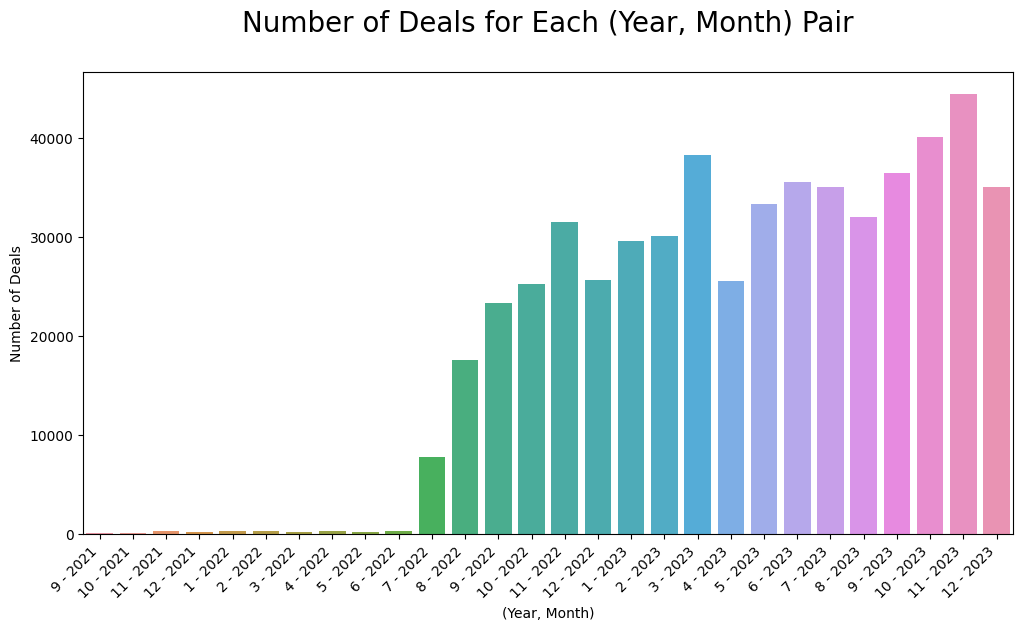

In [315]:
# Extract year and month from 'Deal_Date'
df_preprocessed['Year'] = df_preprocessed['Deal_Date'].dt.year
df_preprocessed['Month'] = df_preprocessed['Deal_Date'].dt.month
counts_df = df_preprocessed.groupby(['Year', 'Month']).size().reset_index(name='Counts')
counts_df['Year_Month'] = counts_df['Month'].astype(str) + ' - ' + counts_df['Year'].astype(str)

# Plot the histogram
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Year_Month', y='Counts', data=counts_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Number of Deals for Each (Year, Month) Pair\n', fontsize=20)
plt.xlabel('(Year, Month)')
plt.ylabel('Number of Deals')
plt.show()

A. **maturity analysis**

In [316]:
df_preprocessed['maturity'].isnull().sum()

0

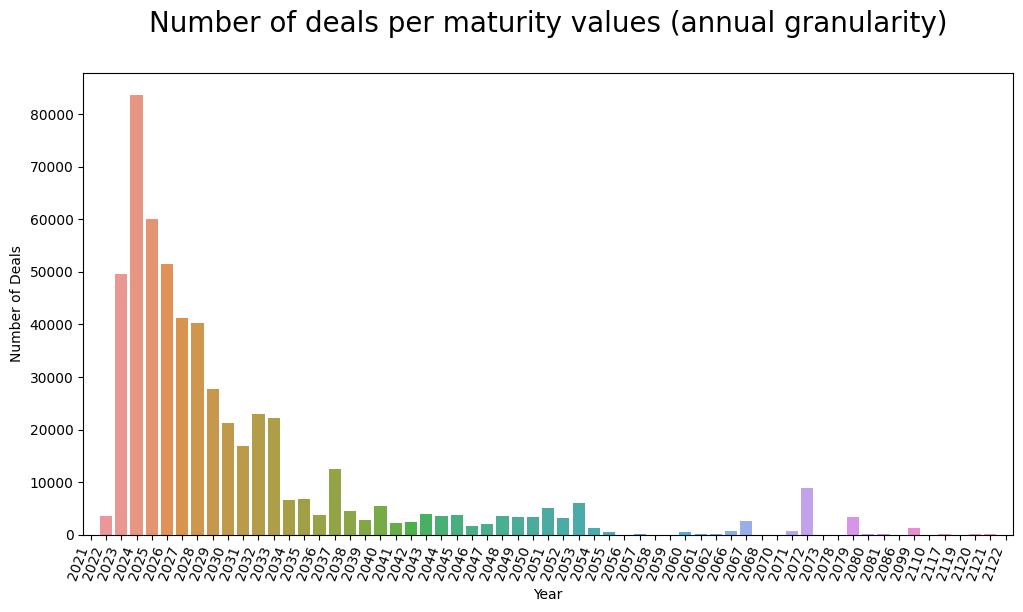

In [320]:
df_maturity = df_preprocessed.dropna(subset=['maturity'], inplace=False)
df_maturity['Maturity_Year'] = df_maturity['maturity'].dt.year
df_maturity = df_maturity.groupby('Maturity_Year').size().reset_index(name='Counts')
df_maturity.sort_values(by='Maturity_Year', ascending=True)


# Plot the histogram
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Maturity_Year', y='Counts', data=df_maturity)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
plt.title('Number of deals per maturity values (annual granularity)\n', fontsize=20)
plt.xlabel('Year')
plt.ylabel('Number of Deals')
plt.show()

C. **company_short_name analysis**

In [321]:
number_of_comp = len(df_preprocessed.company_short_name.values)
print("Number of companies : ", number_of_comp)

Number of companies :  548521


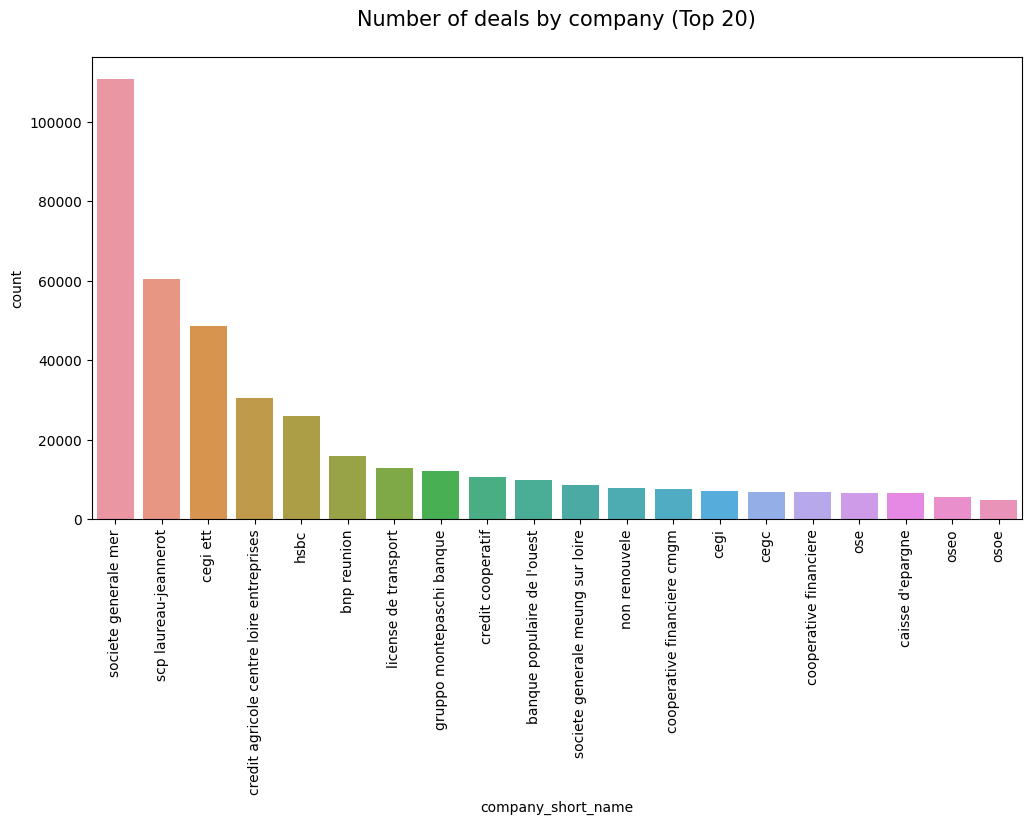

In [322]:
# Histogramme du nombre de deals par company_short_name (top 20)
plt.figure(figsize=(12, 6))
top_20_companies = df_preprocessed['company_short_name'].value_counts().head(20)
sns.countplot(x='company_short_name', data=df_preprocessed, order=top_20_companies.index)
plt.title('Number of deals by company (Top 20)\n', fontsize=15)
plt.xticks(rotation=90)
plt.show()


D. **B_Sides analysis**

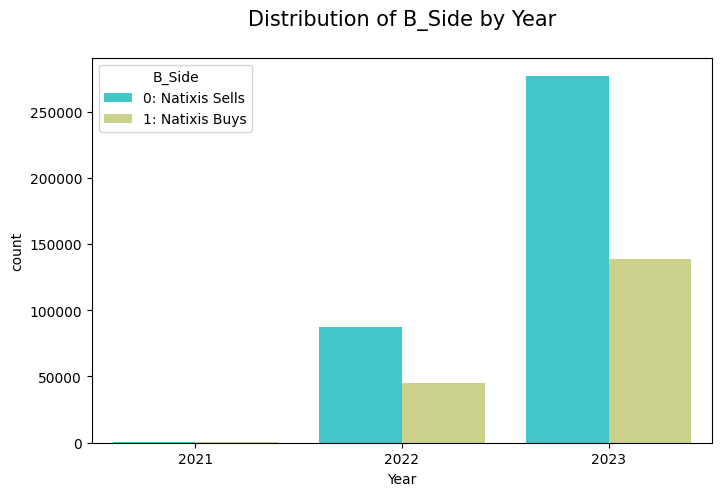

In [323]:
plt.figure(figsize=(8, 5))
palette = sns.color_palette("rainbow", n_colors=2)
sns.countplot(x='Year', hue='B_Side', data=df_preprocessed, palette=palette)
plt.legend(title='B_Side', labels=['0: Natixis Sells', '1: Natixis Buys'])
plt.title('Distribution of B_Side by Year\n', fontsize=15)
plt.show()

E. **BloomIndustrySector analysis**

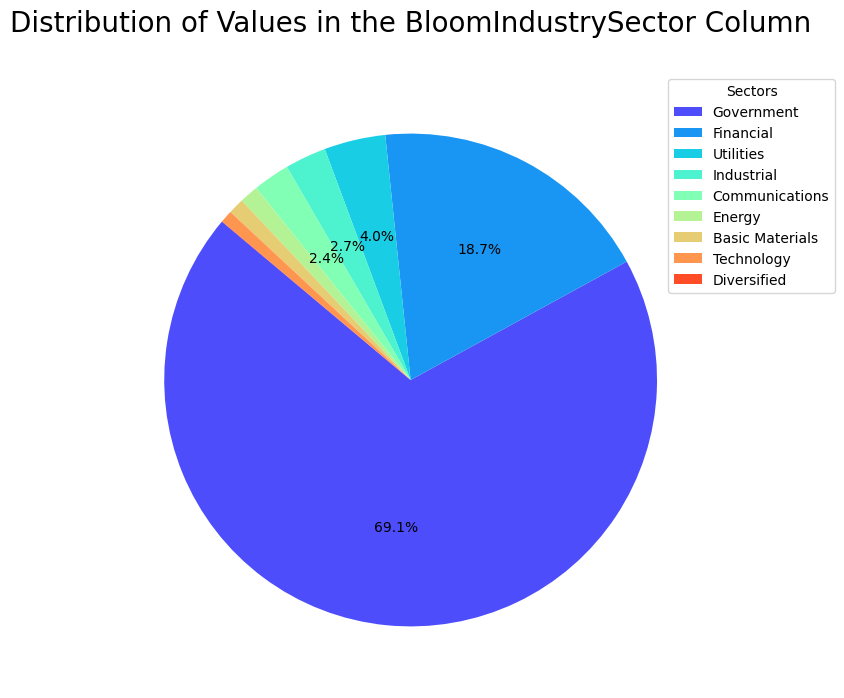

In [349]:
sector_counts = df_preprocessed['BloomIndustrySector'].value_counts()
colors = sns.color_palette('rainbow', len(sector_counts))

# Set the threshold for displaying percentages
percentage_threshold = 2
def autopct_func(pct):
    return f'{pct:.1f}%' if pct >= percentage_threshold else ''

# Plot the pie chart without labels
plt.figure(figsize=(10, 8))
plt.pie(sector_counts, labels=None, autopct=autopct_func, startangle=140, colors=colors)
plt.legend(sector_counts.index, title='Sectors', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.title('Distribution of Values in the BloomIndustrySector Column\n', fontsize=20)
plt.show()


In [345]:
number_industries = len(df_preprocessed['BloomIndustryGroup'].unique())
print('Number of industries : ', number_industries)
df_preprocessed.BloomIndustryGroup.value_counts()

Number of industries :  47


BloomIndustryGroup
Sovereign                   363607
Banks                        84317
Electric                     19351
Multi-National               10807
Telecommunications           10036
Oil&Gas                       6368
Diversified Finan Serv        5318
Engineering&Construction      4690
REITS                         4637
Regional(state/provnc)        3725
Real Estate                   3343
Insurance                     3319
Miscellaneous Manufactur      2959
Computers                     2627
Chemicals                     2589
Iron/Steel                    2417
Transportation                2276
Building Materials            1887
Water                         1719
Internet                      1681
Software                      1173
Electrical Compo&Equip        1135
Gas                            957
Media                          930
Aerospace/Defense              845
Mining                         664
Investment Companies           605
Savings&Loans                  572
A

In [346]:
number_subindustries = len(df_preprocessed['BloomIndustrySubGroup'].unique())
print('Number of sub industries : ', number_subindustries)
df_preprocessed.BloomIndustrySubGroup.value_counts()

Number of sub industries :  138


BloomIndustrySubGroup
Sovereign                   356195
Commer Banks Non-US          41431
Diversified Banking Inst     29096
Supranational Bank           10807
Electric-Integrated           9111
                             ...  
Aerospace/Defense                2
Machinery-Electric Util          2
Independ Power Producer          1
Metal Processors&Fabrica         1
Multimedia                       1
Name: count, Length: 138, dtype: int64